In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-0.664102611132
-10.0
0.07734895
37808


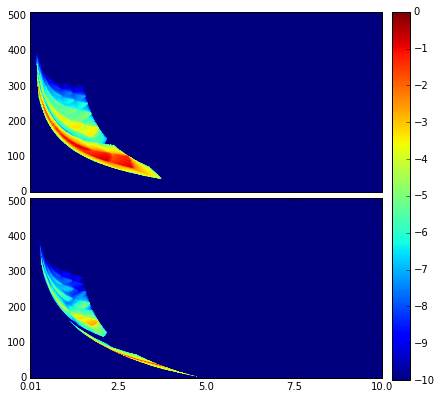

In [164]:
from calc_scattering import calc_scattering
import sim_consts as sc
import time
from matplotlib.colors import LogNorm


f = 11455
L = 3
directory = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/out_35' 

pN_file=os.path.join(directory, 'pN%g_%g.dat'%(f,L))
pS_file=os.path.join(directory, 'pS%g_%g.dat'%(f,L))

# This version for text files
pN = np.loadtxt(pN_file)
pS = np.loadtxt(pS_file)
#pN = np.flipud(pN)
#pS = np.flipud(pS)

tvec = np.linspace(sc.T_STEP,sc.T_MAX,sc.NUM_STEPS)

clims = [-10, 0]


pN_P = np.log10(pN)
np.clip(pN_P,clims[0],clims[1],out=pN_P)

pS_P = np.log10(pS)
np.clip(pS_P,clims[0],clims[1],out=pS_P)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

p1 = ax1.imshow(pN_P,origin='lower')
p1.set_clim(clims)
p2 = ax2.imshow(pS_P,origin='lower')
p2.set_clim(clims)

cax = fig.add_axes([0.77, 0.12, 0.025, 0.78])
fig.colorbar(p1,cax=cax)


ax1.get_xaxis().set_visible(False)
ax2.set_xticks(np.floor(np.linspace(0,sc.NUM_STEPS-1,5)))
ax2.set_xticklabels(tvec[ax2.get_xticks().astype(int)])

# print ax1.get_yticks()
# ax1.set_yticks(np.floor(np.linspace(0,sc.NUM_E - 1,5)))
# ax1.set_yticklabels(sc.E_tot_arr[ax1.get_yticks().astype(int)])

fig.subplots_adjust(hspace=0.03, wspace=0.05)
fig.canvas.draw()

print np.max(pN_P)
print np.min(pN_P)
print np.max(pS)
print sum(sum((pN!=0)))



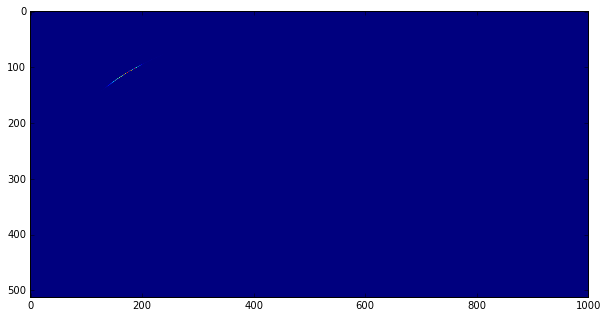

In [22]:
np.where(pN == np.max(pN))

plt.imshow(pS)

In [ ]:
import re

directory = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/' 
L = 3

def load_pfiles(directory, L):
    # Get files, frequencies:
    d = os.listdir(directory)


    freqs_pN = []
    freqs_pS = []
    l_pN = []
    l_pS = []

    p = re.compile("\d+")
    for s in d:
        if s.endswith(".dat"):
            if s.startswith('pN'):
                tmp = p.findall(s)
                freqs_pN.append(int(tmp[0]))
                l_pN.append(float(tmp[1]))

            elif s.startswith('pS'):
                tmp = p.findall(s)
                freqs_pS.append(int(tmp[0]))
                l_pS.append(float(tmp[1]))

    freqs_pN.sort()
    freqs_pS.sort()

    # print l_pN
    assert freqs_pN == freqs_pS, "frequency mismatch!"

    freqs = freqs_pN

    pN = []
    pS = []

    # for f, l in zip(freqs, l_pN):
    for f in freqs:
        pN.append(np.loadtxt(os.path.join(directory,"pN%d_%d.dat"%(f,L))))
        pS.append(np.loadtxt(os.path.join(directory,"pS%d_%d.dat"%(f,L))))

    #print np.shape(pN)
    #print np.shape(pS)
    return pN, pS

In [ ]:
pN, pS = load_pfiles(directory, L)


In [ ]:
import sim_consts as sc
from matplotlib.colors import LogNorm


pN_sum = np.sqrt(np.sum(pN, axis=0))
pS_sum = np.sqrt(np.sum(pS, axis=0))


clims = [0.1,2]
tvec = np.linspace(0,sc.T_MAX,sc.NUM_STEPS)

plt.figure()
# plt.imshow(pS_sum)
# plt.subplot(211)
# plt.imshow(pN_sum)
plt.pcolor(tvec, sc.E_tot_arr*1e-6, pS_sum,  norm=LogNorm(vmin=clims[0], vmax=clims[1]))
plt.clim(clims)
plt.colorbar()
# plt.subplot(212)
#plt.imshow(pS_sum)
# plt.pcolor(tvec, sc.E_tot_arr, pS_sum)


print np.max(pN_sum)
print np.max(pS_sum)
print sum(sum(sum(np.isnan(pN))))
print sum(sum(sum(np.isnan(pS))))





In [ ]:
import sim_consts as sc 
tmp = pow(10,sc.E_EXP_BOT + sc.DE_EXP*np.arange(0,sc.NUM_E))
print np.shape(tmp)
print 